In [68]:
%load_ext google.cloud.bigquery
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


This will select data from BQ into a dataframe

In [69]:
%%bigquery prices
SELECT * FROM sell_prices.sell_prices where store_id = 'CA_1';

In [70]:
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [71]:
%%bigquery calendar
SELECT * FROM `kaggle-covid.calendar.calendar`;


In [72]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-02-19,11104,Saturday,1,2,2011,d_22,None,None,None,None,0,0,0
2,2011-02-26,11105,Saturday,1,2,2011,d_29,None,None,None,None,0,0,0
3,2011-03-19,11108,Saturday,1,3,2011,d_50,None,None,None,None,0,0,0
4,2011-03-26,11109,Saturday,1,3,2011,d_57,None,None,None,None,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-03-11,11606,Friday,7,3,2016,d_1869,None,None,None,None,0,1,1
1965,2016-04-08,11610,Friday,7,4,2016,d_1897,None,None,None,None,1,0,1
1966,2016-04-15,11611,Friday,7,4,2016,d_1904,None,None,None,None,0,1,1
1967,2016-05-06,11614,Friday,7,5,2016,d_1925,None,None,None,None,1,1,1


In [73]:
%%bigquery item_013
-- select one item in one store
select 
*
from
sales_train_evaluation.sales_train_evaluation a
where a.store_id = 'CA_1' and a.item_id = 'HOBBIES_1_013';

In [74]:
item_013

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_013_CA_1_evaluation,HOBBIES_1_013,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,1,0,0,0,0,0,1,1


In [75]:
%%bigquery store_CA_1
-- select all items from one store
select 
*
from
sales_train_evaluation.sales_train_evaluation a
where a.store_id = 'CA_1';

In [76]:
store_CA_1

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
4,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,FOODS_3_319_CA_1_evaluation,FOODS_3_319,FOODS_3,FOODS,CA_1,CA,5,11,11,15,...,0,0,0,0,0,0,0,0,0,0
3045,FOODS_3_681_CA_1_evaluation,FOODS_3_681,FOODS_3,FOODS,CA_1,CA,12,11,14,6,...,25,25,28,6,15,14,29,29,17,45
3046,FOODS_3_080_CA_1_evaluation,FOODS_3_080,FOODS_3,FOODS,CA_1,CA,33,16,16,14,...,14,19,26,15,15,26,17,15,22,21
3047,FOODS_3_586_CA_1_evaluation,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,42,36,30,23,...,42,45,71,34,46,33,18,33,48,43


Pivot all the date columns into rows to get something more amenable for time series prediction 

In [77]:
df = pd.melt(
    store_CA_1,
    id_vars=[
        'id',
        'item_id',
        'dept_id',
        'cat_id',
        'store_id',
        'state_id'
    ],
    var_name='d',
    value_name='items_sold'
).dropna()

In [78]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,items_sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
...,...,...,...,...,...,...,...,...
5918104,FOODS_3_319_CA_1_evaluation,FOODS_3_319,FOODS_3,FOODS,CA_1,CA,d_1941,0
5918105,FOODS_3_681_CA_1_evaluation,FOODS_3_681,FOODS_3,FOODS,CA_1,CA,d_1941,45
5918106,FOODS_3_080_CA_1_evaluation,FOODS_3_080,FOODS_3,FOODS,CA_1,CA,d_1941,21
5918107,FOODS_3_586_CA_1_evaluation,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,d_1941,43


Join with calendar dataframe

In [79]:
df = pd.merge(df, calendar, on='d', how='left')
df

,id,item_id,dept_id,cat_id,store_id,state_id,d,items_sold,date,wm_yr_wk,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,None,None,None,None,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,None,None,None,None,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,None,None,None,None,0,0,0
3,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,None,None,None,None,0,0,0
4,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,1,2011,None,None,None,None,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5918104,FOODS_3_319_CA_1_evaluation,FOODS_3_319,FOODS_3,FOODS,CA_1,CA,d_1941,0,2016-05-22,11617,...,2,5,2016,None,None,None,None,0,0,0
5918105,FOODS_3_681_CA_1_evaluation,FOODS_3_681,FOODS_3,FOODS,CA_1,CA,d_1941,45,2016-05-22,11617,...,2,5,2016,None,None,None,None,0,0,0
5918106,FOODS_3_080_CA_1_evaluation,FOODS_3_080,FOODS_3,FOODS,CA_1,CA,d_1941,21,2016-05-22,11617,...,2,5,2016,None,None,None,None,0,0,0
5918107,FOODS_3_586_CA_1_evaluation,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,d_1941,43,2016-05-22,11617,...,2,5,2016,None,None,None,None,0,0,0


In [80]:
df_d = df.groupby(['d'])['items_sold'].sum().dropna().reset_index()
df_d

,d,items_sold
0,d_1,4337
1,d_10,3157
2,d_100,3033
3,d_1000,3072
4,d_1001,3955
...,...,...
1936,d_995,5147
1937,d_996,5914
1938,d_997,3742
1939,d_998,3349


Now join with item prices for each item within store for that date (wm_yrwk).

In [81]:
df = pd.merge(
    df,
    prices,
    on=['store_id','item_id','wm_yr_wk'],
    how='left') 

In [82]:
df.describe

<bound method NDFrame.describe of                                     id        item_id    dept_id   cat_id  \
0        HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1        HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2        HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3        HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
4        HOBBIES_1_007_CA_1_evaluation  HOBBIES_1_007  HOBBIES_1  HOBBIES   
...                                ...            ...        ...      ...   
5918104    FOODS_3_319_CA_1_evaluation    FOODS_3_319    FOODS_3    FOODS   
5918105    FOODS_3_681_CA_1_evaluation    FOODS_3_681    FOODS_3    FOODS   
5918106    FOODS_3_080_CA_1_evaluation    FOODS_3_080    FOODS_3    FOODS   
5918107    FOODS_3_586_CA_1_evaluation    FOODS_3_586    FOODS_3    FOODS   
5918108    FOODS_3_587_CA_1_evaluation    FOODS_3_587    FOODS_3    FOODS   

        store_id state_id       d  items_

In [83]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,items_sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,None,None,None,None,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,None,None,None,None,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,None,None,None,None,0,0,0,NaN
3,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,None,None,None,None,0,0,0,NaN
4,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,None,None,None,None,0,0,0,NaN


In [84]:
df.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            5918099, 5918100, 5918101, 5918102, 5918103, 5918104, 5918105,
            5918106, 5918107, 5918108],
           dtype='int64', length=5918109)

In [85]:
df.loc[df['wm_yr_wk'] == 11101]

,id,item_id,dept_id,cat_id,store_id,state_id,d,items_sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,None,None,None,None,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,None,None,None,None,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,None,None,None,None,0,0,0,NaN
3,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,None,None,None,None,0,0,0,NaN
4,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,None,None,None,None,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21338,FOODS_3_319_CA_1_evaluation,FOODS_3_319,FOODS_3,FOODS,CA_1,CA,d_7,13,2011-02-04,11101,...,2,2011,None,None,None,None,1,0,0,1.00
21339,FOODS_3_681_CA_1_evaluation,FOODS_3_681,FOODS_3,FOODS,CA_1,CA,d_7,11,2011-02-04,11101,...,2,2011,None,None,None,None,1,0,0,1.25
21340,FOODS_3_080_CA_1_evaluation,FOODS_3_080,FOODS_3,FOODS,CA_1,CA,d_7,24,2011-02-04,11101,...,2,2011,None,None,None,None,1,0,0,1.48
21341,FOODS_3_586_CA_1_evaluation,FOODS_3_586,FOODS_3,FOODS,CA_1,CA,d_7,30,2011-02-04,11101,...,2,2011,None,None,None,None,1,0,0,1.48


In [86]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [87]:
df_sales = df.groupby(['date', 'cat_id'])['items_sold'].sum().dropna().reset_index()

In [88]:
df_sales.index

RangeIndex(start=0, stop=5823, step=1)

In [89]:
df_sales.tail()

,date,cat_id,items_sold
5818,2016-05-21,HOBBIES,719
5819,2016-05-21,HOUSEHOLD,1262
5820,2016-05-22,FOODS,4327
5821,2016-05-22,HOBBIES,646
5822,2016-05-22,HOUSEHOLD,1316


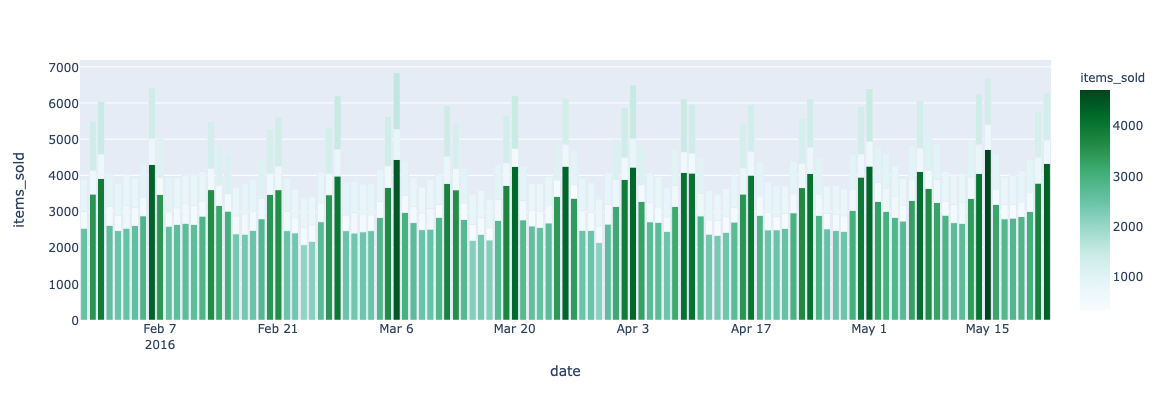

In [96]:
def plot_values(df, from_date=None, target=None):
    fig = px.bar(df.loc[df['date'] >= from_date], x='date', \
             y='items_sold', color="items_sold",\
             width=800, height=400, color_continuous_scale=px.colors.sequential.BuGn)
    fig.show()
    
plot_values(df_sales, '2016-01-29')

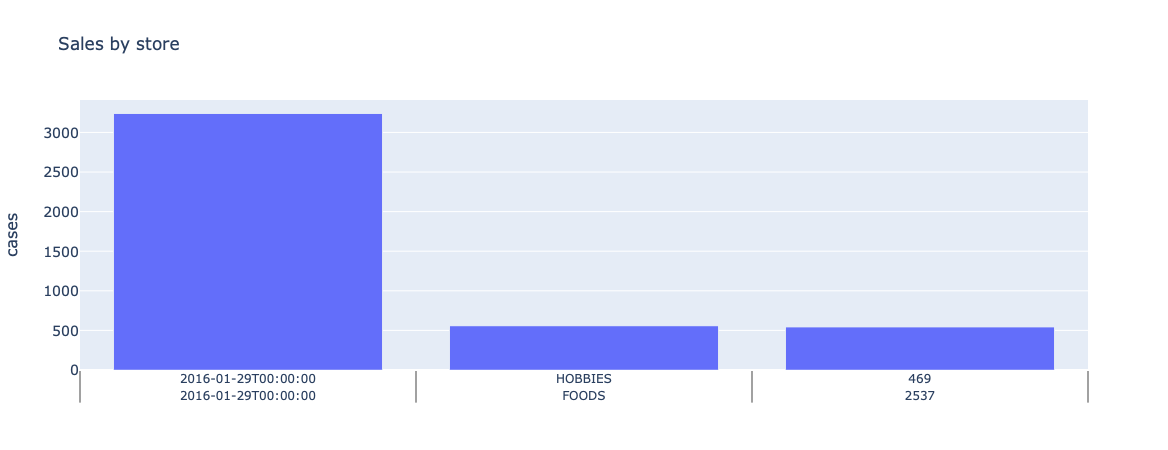

In [103]:
def plot_grouped_values(df, from_date):
    fig = go.Figure(data=[
        go.Bar(name='predicted', x=(df.loc[df['date'] >= from_date]), y=df['items_sold'], hovertext=df['cat_id'])
    ])
    # Change the bar mode
    fig.update_layout(barmode='group',
        title='Sales by store',
        yaxis=dict(
            title='cases',
            titlefont_size=16,
            tickfont_size=14,
        ))
    fig.show()
    
plot_grouped_values(df_sales, '2016-01-29')